In [2]:
!pip install pyspark 
!pip install -U -q PyDrive
!apt update
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
cur_path = "/content/drive/MyDrive/insider-risk-in-spark/"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/insider-risk-in-spark


In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('proj').getOrCreate()

In [6]:
from pyspark.sql.functions import to_timestamp, hour, minute, second
from pyspark.mllib.stat import KernelDensity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [7]:
device = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/device.csv',inferSchema=True,header=True)
email = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/email.csv',inferSchema=True,header=True)
file = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/file.csv',inferSchema=True,header=True)
logon = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/logon.csv',inferSchema=True,header=True)
psychometric = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/psychometric.csv',inferSchema=True,header=True)
user_file = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/user_file.csv',inferSchema=True,header=True)

In [10]:
!pip install findspark
import findspark
findspark.find()

ValueError: ignored

In [8]:
user_file.show(5)

+---+----------+-------+---+
|_c0|  new_date|   user| id|
+---+----------+-------+---+
|  0|2010-01-02|ABK3081|  1|
|  1|2010-01-02|NSR2539|  6|
|  2|2010-01-02|NRT1320|  1|
|  3|2010-01-02|NBT3447|  1|
|  4|2010-01-02|MWG1570|  4|
+---+----------+-------+---+
only showing top 5 rows



In [ ]:
device = device.withColumn('date', to_timestamp(device.date, 'MM/dd/yyyy HH:mm:ss'))
device = device.withColumn('hour', hour('date')+minute('date')/60+second('date')/3600)
device.printSchema()
device.show(5)

root
 |-- id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- user: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- activity: string (nullable = true)
 |-- hour: double (nullable = true)

+--------------------+-------------------+-------+-------+----------+------------------+
|                  id|               date|   user|     pc|  activity|              hour|
+--------------------+-------------------+-------+-------+----------+------------------+
|{J1S3-L9UU75BQ-77...|2010-01-02 07:21:06|MOH0273|PC-6699|   Connect| 7.351666666666667|
|{N7B5-Y7BB27SI-29...|2010-01-02 07:37:41|MOH0273|PC-6699|Disconnect| 7.628055555555556|
|{U1V9-Z7XT67KV-56...|2010-01-02 07:59:11|HPH0075|PC-2417|   Connect|7.9863888888888885|
|{H0Z7-E6GB57XZ-16...|2010-01-02 07:59:49|IIW0249|PC-0843|   Connect| 7.996944444444445|
|{L7P2-G4PX02RX-79...|2010-01-02 08:04:26|IIW0249|PC-0843|Disconnect| 8.073888888888888|
+--------------------+-------------------+-------+-------+-----

In [ ]:
def get_kde_graph(prob, new_hour, new_prob):
    prob_max = max(prob)
    prob_min = min(prob)
    all24hour = list(np.arange(0,24,0.1))

    plt.plot(all24hour,prob)
    plt.xlim(0, 24)
    plt.hlines(new_prob, 0, 24, colors = "red", alpha = 0.5)
    plt.vlines(new_hour, 0, prob_max, colors = "red", alpha = 0.5)
    plt.title("History KDE Curve")
    plt.show()

def get_score(new_hour, prob, kd):
    prob_max = max(prob)
    prob_min = min(prob)
    new_prob = kd.estimate([float(new_hour)])

    get_kde_graph(prob, new_hour, new_prob)

    risk_score = (prob_max-new_prob)/(prob_max - prob_min)
    return risk_score[0]



In [ ]:
user = 'IIW0249'
new_hour = 12

In [ ]:
all_device_connect_hour = device.where("activity == 'Connect'").select('hour')
kd_all_device = KernelDensity()
kd_all_device.setSample(all_device_connect_hour.rdd.map(lambda x: x[0]))

all24hour = list(np.arange(0,24,0.1))
prob_all_device = kd_all_device.estimate(all24hour)

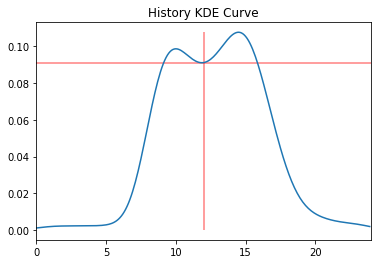

0.15492519216702494

In [ ]:
get_score(new_hour, prob_all_device, kd_all_device)  

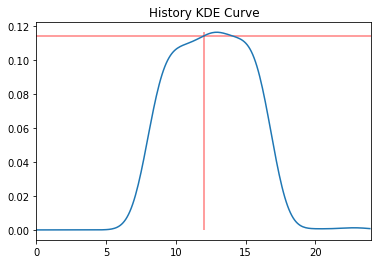

0.018223924062195616

In [ ]:
personal_connect_hour = device.where("activity == 'Connect'").where("user == '"+ user +"'").select('hour')
kd_personal = KernelDensity()
kd_personal.setSample(personal_connect_hour.rdd.map(lambda x: x[0]))

all24hour = list(np.arange(0,24,0.1))
prob_personal = kd_personal.estimate(all24hour)

get_score(new_hour, prob_personal, kd_personal)  

In [ ]:
email = email.withColumn('date', to_timestamp(email.date, 'MM/dd/yyyy HH:mm:ss'))

email.printSchema()
email.show(5)

root
 |-- id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- user: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- to: string (nullable = true)
 |-- cc: string (nullable = true)
 |-- bcc: string (nullable = true)
 |-- from: string (nullable = true)
 |-- size: integer (nullable = true)
 |-- attachments: integer (nullable = true)
 |-- content: string (nullable = true)

+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+
|                  id|               date|   user|     pc|                  to|                  cc|                 bcc|                from| size|attachments|             content|
+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+
|{R3I7-S4TX96FG-82...|2010-01-02 07:11:45|LAP0

In [ ]:
file = file.withColumn('date', to_timestamp(file.date, 'MM/dd/yyyy HH:mm:ss'))

file.printSchema()
file.show(5)

root
 |-- id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- user: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- content: string (nullable = true)

+--------------------+-------------------+-------+-------+------------+--------------------+
|                  id|               date|   user|     pc|    filename|             content|
+--------------------+-------------------+-------+-------+------------+--------------------+
|{L9G8-J9QE34VM-28...|2010-01-02 07:23:14|MOH0273|PC-6699|EYPC9Y08.doc|D0-CF-11-E0-A1-B1...|
|{H0W6-L4FG38XG-98...|2010-01-02 07:26:19|MOH0273|PC-6699|N3LTSU3O.pdf|25-50-44-46-2D ca...|
|{M3Z0-O2KK89OX-57...|2010-01-02 08:12:03|HPH0075|PC-2417|D3D3WC9W.doc|D0-CF-11-E0-A1-B1...|
|{E1I4-S4QS61TG-36...|2010-01-02 08:17:00|HPH0075|PC-2417|QCSW62YS.doc|D0-CF-11-E0-A1-B1...|
|{D4R7-E7JL45UX-00...|2010-01-02 08:24:57|HSB0196|PC-8001|AU75JV6U.jpg|               FF-D8|
+--------------------+------

In [ ]:
logon = logon.withColumn('date', to_timestamp(logon.date, 'MM/dd/yyyy HH:mm:ss'))

logon.printSchema()
logon.show(5)

root
 |-- id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- user: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- activity: string (nullable = true)

+--------------------+-------------------+-------+-------+--------+
|                  id|               date|   user|     pc|activity|
+--------------------+-------------------+-------+-------+--------+
|{X1D9-S0ES98JV-53...|2010-01-02 06:49:00|NGF0157|PC-6056|   Logon|
|{G2B3-L6EJ61GT-22...|2010-01-02 06:50:00|LRR0148|PC-4275|   Logon|
|{U6Q3-U0WE70UA-37...|2010-01-02 06:53:04|LRR0148|PC-4124|   Logon|
|{I0N5-R7NA26TG-62...|2010-01-02 07:00:00|IRM0931|PC-7188|   Logon|
|{D1S0-N6FH62BT-53...|2010-01-02 07:00:00|MOH0273|PC-6699|   Logon|
+--------------------+-------------------+-------+-------+--------+
only showing top 5 rows



In [ ]:
psychometric.printSchema()
psychometric.show(5)

root
 |-- employee_name: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- O: integer (nullable = true)
 |-- C: integer (nullable = true)
 |-- E: integer (nullable = true)
 |-- A: integer (nullable = true)
 |-- N: integer (nullable = true)

+--------------------+-------+---+---+---+---+---+
|       employee_name|user_id|  O|  C|  E|  A|  N|
+--------------------+-------+---+---+---+---+---+
|    Calvin Edan Love|CEL0561| 40| 39| 36| 19| 40|
|Christine Reagan ...|CRD0624| 26| 22| 17| 39| 32|
|Jade Felicia Cald...|JFC0557| 22| 16| 23| 40| 33|
|Aquila Stewart De...|ASD0577| 40| 48| 36| 14| 37|
|   Micah Abdul Rojas|MAR0955| 36| 44| 23| 44| 25|
+--------------------+-------+---+---+---+---+---+
only showing top 5 rows

